In [ ]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("./data/lfw/*/*"))
dog_files = np.array(glob("./data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

In [ ]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(VGG16):,} trainable parameters')

In [ ]:
VGG16.classifier[-1]

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    img = load_image(img_path)
    if use_cuda:
        img = img.cuda()
    ret = VGG16(img) 
    
    ## Return the *index* of the predicted class for that image
        
    return torch.max(ret,1)[1].item() # predicted class index

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as datasets

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

def load_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    # resize to (244, 244) because VGG16 accept this shape
    train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
    
    test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = train_transforms(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    value=VGG16_predict(img_path)
    if 268>=value>=151:
      return True
    else:
      return False
    #return None # true/false

In [ ]:
url2='./Data/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'
url3='./Data/dogImages/test/006.American_eskimo_dog/American_eskimo_dog_00406.jpg'
url4='./Data/lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg'

print(dog_detector(url2))
print(dog_detector(url3))
print(dog_detector(url4))

In [ ]:
from tqdm import tqdm
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

count=0
count2=0
for i in tqdm(range(len(human_files_short))):
  if dog_detector(human_files_short[i])==True:
    count+=1
  if dog_detector(dog_files_short[i])==True:
    count2+=1

print('')
print(count/len(human_files_short),count2/len(dog_files_short))

In [ ]:
pip install efficientnet_pytorch

In [ ]:
import random
import torch
import numpy as np
#seed_value = 1234
seed_value = 1000
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True

In [1]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets
import torch.utils.data as data
import torchvision.datasets as datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(256),
                           transforms.RandomPerspective(0.5,0.5,2,0),
                           transforms.RandomHorizontalFlip(),
                           transforms.CenterCrop(224),
                           transforms.ToTensor(), 
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

valid_transforms = transforms.Compose([
                           #transforms.Resize(pretrained_size),#test orig out
                           transforms.Resize(256), #test orig
                           transforms.CenterCrop(224),#test orig 
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           #transforms.Resize(size=(pretrained_size,pretrained_size)),
                           transforms.Resize(256),
                           transforms.CenterCrop(224), #test orig
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [2]:
train_data=datasets.ImageFolder('./Data/dogImages/train',transform=train_transforms)
valid_data=datasets.ImageFolder('./Data/dogImages/valid',transform=valid_transforms)
test_data=datasets.ImageFolder('./Data/dogImages/test',transform=test_transforms)

In [3]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 6680
Number of validation examples: 835
Number of testing examples: 836


In [4]:
BATCH_SIZE = 10

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

loaders= {
    'train': train_iterator,
    'valid': valid_iterator,
    'test': test_iterator}

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = 133

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()

use_cuda = torch.cuda.is_available()

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

In [6]:
#encoder and decoder to convert classes into integer
classes = train_data.classes
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.75E-02


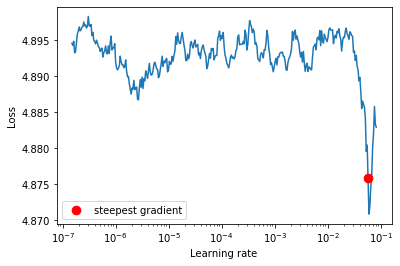

Wall time: 52 s


In [7]:
%%time
#TWEEKED FASTAI
from torch_lr_finder import LRFinder
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = model
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
optimizer = optim.SGD(classifier.parameters(), lr=1e-7,weight_decay=1e-2)
lr_finder = LRFinder(classifier, optimizer, criterion, device=device)
lr_finder.range_test(train_iterator, end_lr=0.1, num_iter=350)
#lr_finder.range_test(train_iterator, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their in

In [ ]:
%%time
#LESLIE SMITH
from torch_lr_finder import LRFinder
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-2)
optimizer = optim.SGD(classifier.parameters(), lr=0.001, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_iterator, val_loader=valid_iterator, end_lr=0.1, num_iter=40, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [8]:
import torch.optim as optim

#FOUND_LR = 1e-3
optimizer = optim.SGD(model.parameters(), lr = 0.0575)
#optimizer = optim.SGD(model.parameters(), lr = 0.0264)
#optimizer = optim.SGD(model.parameters(), lr = 0.000785)
#optimizer = optim.SGD(model.parameters(), lr = 0.000000224)
#optimizer = optim.SGD(model.parameters(), lr = 0.05)
criterion = nn.CrossEntropyLoss() #our loss function (which will also apply the softmax activation function)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to put our model and data on the GPU

#model = model.to(device) # colocando el modelo en el device
criterion = criterion.to(device) # colocando el criterio en el device

In [12]:
import os
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda,save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
              
    # return trained model
    return model

In [13]:
%%time
# train the model
model_scratch = train(25, loaders, model, optimizer,criterion, use_cuda, 'model_scratch.pt')
#model_scratch = train(10, loaders, classifier, optimizer,criterion, True, 'model_scratch.pt')

Epoch 1, Batch 1 loss: 4.904364
Epoch 1, Batch 101 loss: 4.890393
Epoch 1, Batch 201 loss: 4.888535
Epoch 1, Batch 301 loss: 4.886327
Epoch 1, Batch 401 loss: 4.876527
Epoch 1, Batch 501 loss: 4.866904
Epoch 1, Batch 601 loss: 4.848593
Epoch: 1 	Training Loss: 4.835149 	Validation Loss: 4.651509
Validation loss decreased (inf --> 4.651509).  Saving model ...
Epoch 2, Batch 1 loss: 4.571523
Epoch 2, Batch 101 loss: 4.671921
Epoch 2, Batch 201 loss: 4.637563
Epoch 2, Batch 301 loss: 4.626429
Epoch 2, Batch 401 loss: 4.615039
Epoch 2, Batch 501 loss: 4.602752
Epoch 2, Batch 601 loss: 4.590831
Epoch: 2 	Training Loss: 4.588365 	Validation Loss: 4.459999
Validation loss decreased (4.651509 --> 4.459999).  Saving model ...
Epoch 3, Batch 1 loss: 4.136799
Epoch 3, Batch 101 loss: 4.449347
Epoch 3, Batch 201 loss: 4.433549
Epoch 3, Batch 301 loss: 4.429031
Epoch 3, Batch 401 loss: 4.425333
Epoch 3, Batch 501 loss: 4.419917
Epoch 3, Batch 601 loss: 4.414335
Epoch: 3 	Training Loss: 4.414951 	Va

Epoch 25, Batch 101 loss: 2.829391
Epoch 25, Batch 201 loss: 2.911821
Epoch 25, Batch 301 loss: 2.881733
Epoch 25, Batch 401 loss: 2.941877
Epoch 25, Batch 501 loss: 2.947832
Epoch 25, Batch 601 loss: 2.943673
Epoch: 25 	Training Loss: 2.958499 	Validation Loss: 3.750996
Wall time: 37min 18s


In [14]:
#pwd

In [15]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model, criterion, use_cuda)

Test Loss: 3.566524


Test Accuracy: 17% (143/836)


In [17]:
#TRANSFER

In [ ]:
loaders_transfer = loaders.copy()

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
#model_transfer = models.resnet50(pretrained=True)
#model_transfer = models.resnet18(pretrained=True)
model_transfer = models.alexnet(pretrained=True)

In [ ]:
for param in model_transfer.parameters(): #resnet
    param.requires_grad = False #resnet

#for the last layer
model_transfer.fc = nn.Linear(2048, 133, bias=True) #resnet50

fc_parameters = model_transfer.fc.parameters() #resnet

for param in fc_parameters: #resnet
    param.requires_grad = True #resnet
    
model_transfer

In [ ]:
#use_cuda = torch.cuda.is_available()
#print(use_cuda)
#use_cuda = True
# Reset last layer
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, 133)

In [ ]:
IN_FEATURES = model_transfer.classifier[-1].in_features  #alexnet
final_fc = nn.Linear(IN_FEATURES, 133) #alenext

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to put our model and data on the GPU

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001) #alexnet
#optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001) #resnet

#model_transfer = model_transfer.to(device) # colocando el modelo en el device
#criterion = criterion.to(device) # colocando el criterio en el device

In [ ]:
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))
#model_transfer.load_state_dict(torch.load('model_scratch.pt'))
model_transfer=train(5, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, True, 'model_transfer.pt')

In [ ]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
from PIL import Image
import torchvision.transforms as transforms

def load_input(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     normalize])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    result = prediction(image)[:3,:,:].unsqueeze(0)
    return result

def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input(img_path)
    model = model.cpu()
    model.eval()
    id = torch.argmax(model(img))
    return class_names[id]

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_name: {0}, \t predition breed: {1}".format(img_path, predition))

In [ ]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Dogs Detected!\nIt looks like a {0}".format(prediction))  
    #elif face_detector(img_path) > 0:
     #   prediction = predict_breed_transfer(model_transfer, class_names, img_path)
      #  print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
    else:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

In [ ]:
#for file in np.hstack((human_files[:3], dog_files[:3])):
 #   run_app(file)
for img_file in os.listdir('./images2'):
    img_path = os.path.join('./images2', img_file)
    run_app(img_path)    